In [2]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

%matplotlib inline
import matplotlib.pyplot as plt # библиотека визуализации
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10, 8)})

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.2f}'.format)

## 0. Prerequisites

### 0.0. install LightAutoML

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [3]:
# Standard python libraries
import os
import time

# Essential DS libraries
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

from comet_ml import Experiment
import Handlers as hd

### 0.2. Fix package version

In [4]:
# !pip freeze > requirements.txt

### 0.3. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [5]:
N_THREADS = 4
N_FOLDS = 5
TIMEOUT = 30 * 60 # mins

RANDOM_STATE = 42
TEST_SIZE = 0.2
TARGET_FEATURE = 'reviewer_score'
SUBMISSION_FILE_NAME = 'just_filters.csv'

USE_COMET_ML = False
COMET_PROJECT_NAME = 'Project3'

USE_LAML = False

### 0.4. Init Comet_ML

In [6]:
if USE_COMET_ML:
    experiment = Experiment(
        api_key="I1vM5jywyHjyrHOHaffYqCv6z",
        project_name=COMET_PROJECT_NAME,
        workspace="chepell",
    )

In [7]:
# Save text info about experiment on Comet_ML
if USE_COMET_ML:
    text = SUBMISSION_FILE_NAME + '\nГод в возраст и фильтрация по тьюки\n'
    text = text + 'Фильтрация милей по тьюки\n'
    text = text + 'Фильтрация целевого признака по логике и тьюки\n'

    experiment.log_text(text, step=None, metadata=None)

### 0.5. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [8]:
if USE_LAML:
    np.random.seed(RANDOM_STATE)
    torch.set_num_threads(N_THREADS)

### 0.6. Data loading
Let's check the data we have:

In [9]:
INPUT_DIR = 'data/'

In [10]:
train_data = pd.read_csv(INPUT_DIR + 'hotels_train.csv.zip')
print(train_data.shape)
train_data.head()

(386803, 17)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.40,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.00,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.51,-0.14
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.30,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.30,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.52,-0.12
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.90,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.50,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.85,2.33
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.50,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.00,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.89,2.39
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.50,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.60,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.39,4.85


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [12]:
test_data = pd.read_csv(INPUT_DIR + 'hotels_test.csv.zip')
print(test_data.shape)
test_data.head()

(128935, 16)


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.10,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.53,9.17
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.60,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.39,4.83
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.30,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.39,2.16
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.10,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.48,9.20
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.10,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.37,4.89


In [13]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [14]:
submission = pd.read_csv(INPUT_DIR + 'submission.csv.zip')
print(submission.shape)
submission.head()

(128935, 2)


,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [15]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


### 0.6. Merge datasets

In [16]:
full_data = hd.merge_train_and_test_data(train_data, test_data, TARGET_FEATURE)
full_data.shape

(515738, 18)

### 0.7. EDA

### Duplicates

In [17]:
duplicate_mask = full_data.duplicated()

In [18]:
# Всего дубликатов
duplicate_mask.sum()

336

In [19]:
# % дубликатов
duplicate_mask.mean() * 100

0.06514935878294793

In [20]:
# Сами дубликаты
duplicate_data = full_data[duplicate_mask]
duplicate_data


,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,reviewer_score,dataset
21413,9 Rue Sainte Beuve 6th arr 75006 Paris France,22,9/27/2015,8.90,Hotel Le Sainte Beuve,Costa Rica,No Negative,0,143,Ir s a lovely boutique hotel full of Parisian...,53,4,"[' Leisure trip ', ' Family with older childre...",676 day,48.84,2.33,10.00,train
53110,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,9/25/2016,9.00,H tel Baume,Lebanon,nothing at all,4,253,bed was great staff are wonderful location ve...,10,1,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",312 day,48.85,2.34,10.00,train
54461,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,8/2/2016,7.90,H tel Concorde Montparnasse,Israel,The room to far from elevator,7,2515,Staff very nice and helpful Breakfast was per...,17,2,"[' Couple ', ' Classic Twin Room ', ' Stayed 3...",366 day,48.84,2.32,8.30,train
56542,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,7/2/2017,9.00,H tel Baume,Romania,Breakfast was a huge joke It was the worst po...,19,253,Room was great nice and spacious appartment f...,14,7,"[' Leisure trip ', ' Family with young childre...",32 days,48.85,2.34,7.90,train
65789,7 rue Casimir Delavigne 6th arr 75006 Paris Fr...,44,8/11/2015,9.00,H tel Baume,United Kingdom,No Negative,0,253,Friendly reception staff clean bathroom and l...,11,1,"[' Leisure trip ', ' Couple ', ' Superior Doub...",723 day,48.85,2.34,10.00,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499212,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,5/23/2016,7.90,H tel Concorde Montparnasse,United States of America,Nothing I will stay at this hotel again on my...,24,2515,The staff was very helpful and the property w...,21,8,"[' Leisure trip ', ' Family with older childre...",437 day,48.84,2.32,0.00,test
506924,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,2/1/2016,7.90,H tel Concorde Montparnasse,Malta,beautiful wiew,3,2515,cleanness staff very friendly very helpful,7,2,"[' Leisure trip ', ' Couple ', ' Classic Doubl...",549 day,48.84,2.32,0.00,test
509781,167 rue de Rome 17th arr 75017 Paris France,11,12/12/2016,6.80,Villa Eugenie,Canada,Listed above,3,165,It was a terrible stat unfriendly staff very ...,13,1,"[' Business trip ', ' Solo traveler ', ' Stand...",234 day,48.89,2.31,0.00,test
512237,40 Rue du Commandant Ren Mouchotte 14th arr 75...,228,9/22/2015,7.90,H tel Concorde Montparnasse,Germany,Breakfast is pretty expensive however good,8,2515,Very good location good connections with Metr...,24,5,"[' Leisure trip ', ' Group ', ' Classic Twin R...",681 day,48.84,2.32,0.00,test


In [21]:
# Распределение дубликатов по выборкам
duplicate_data.groupby('dataset').agg({'hotel_name': 'count'})


,hotel_name
dataset,
test,29
train,307


In [22]:
# Можно добавить отдельный признак, что запись дубликат
# Но данный признак будет малоинформативным т.к. будет составлять 0.065% от всей выборки
# full_data['duplicate'] = duplicate_mask

In [23]:
# Удаляю дубликаты
full_data.drop_duplicates(inplace=True)

### Анализ признаков

In [24]:
# Если количество уникальных признаков (Count Unique < 150), то можно думать о переводе признака в категориальный
hd.get_top_unique_values(full_data)

,Column Name,Count Unique,% Unique,Top Value,Top Value Count,Top Value %
0,hotel_address,1493,0.29,163 Marsh Wall Docklands Tower Hamlets London ...,4789,0.93
1,additional_number_of_scoring,480,0.09,2682,4789,0.93
2,review_date,731,0.14,8/2/2017,2584,0.50
3,average_score,34,0.01,8.40,41222,8.00
4,hotel_name,1492,0.29,Britannia International Hotel Canary Wharf,4789,0.93
5,reviewer_nationality,227,0.04,United Kingdom,245158,47.57
6,negative_review,330011,64.03,No Negative,127807,24.80
7,review_total_negative_word_counts,402,0.08,0,127807,24.80
8,total_number_of_reviews,1142,0.22,9086,4789,0.93
9,positive_review,412601,80.05,No Positive,35923,6.97


average_score можно перевести в категориальный признак

In [25]:
# Ишу малоинформативные признаки
hd.get_low_inform_features_list(full_data)

[]

### Изучаю average_score
Похоже на порядковый категориальный признак

In [26]:
# Значения лежат в промежутке 5-10
full_data['average_score'].describe()

count   515402.00
mean         8.40
std          0.55
min          5.20
25%          8.10
50%          8.40
75%          8.80
max          9.80
Name: average_score, dtype: float64

Распределение признака похоже на нормальное

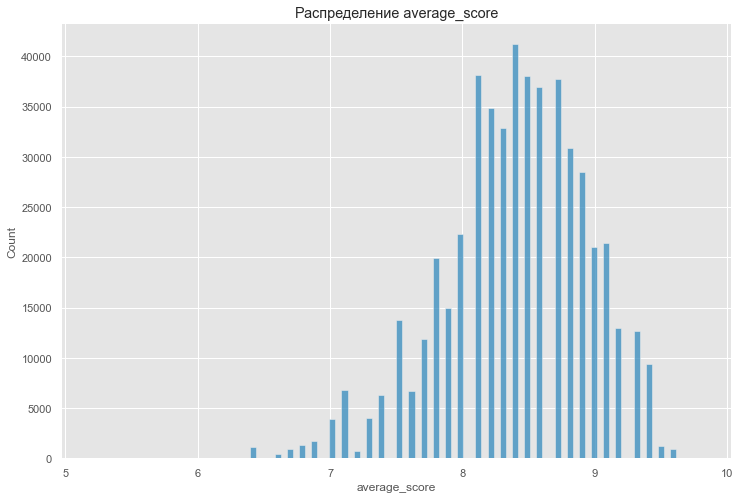

In [27]:
fig = plt.figure(figsize=(12, 8))
hist = sns.histplot(data=full_data, x='average_score', bins=100)
hist.set_title('Распределение average_score');

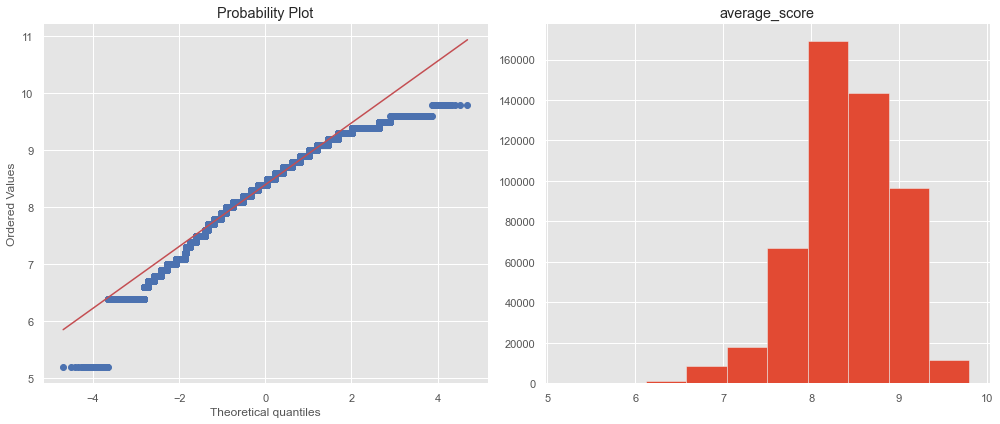

In [28]:
hd.QQ_Plots(full_data, 'average_score')

### average_score, варианты разбиения на категории

In [29]:
# full_data['average_score_cat'] = pd.cut(full_data['average_score'], bins=[5, 6, 7, 8, 9, 10], include_lowest=True)
# full_data['average_score_cat'] = pd.cut(full_data['average_score'], bins=list(np.arange(5, 10.5, 0.5)), include_lowest=True) # C шагом 0.5
# full_data['average_score_cat'] = pd.qcut(full_data['average_score'], q=5) # 5 бинов с примерно одинаковым распределением внутри

# Добавляю новый признак
full_data['average_score_cat'] = pd.cut(full_data['average_score'], bins=[5, 7, 7.5, 8, 8.5, 9, 9.5, 10], labels=['5-6', '7', '7+', '8', '8+', '9', '9+'], include_lowest=True)

### Изучаю lat and lng

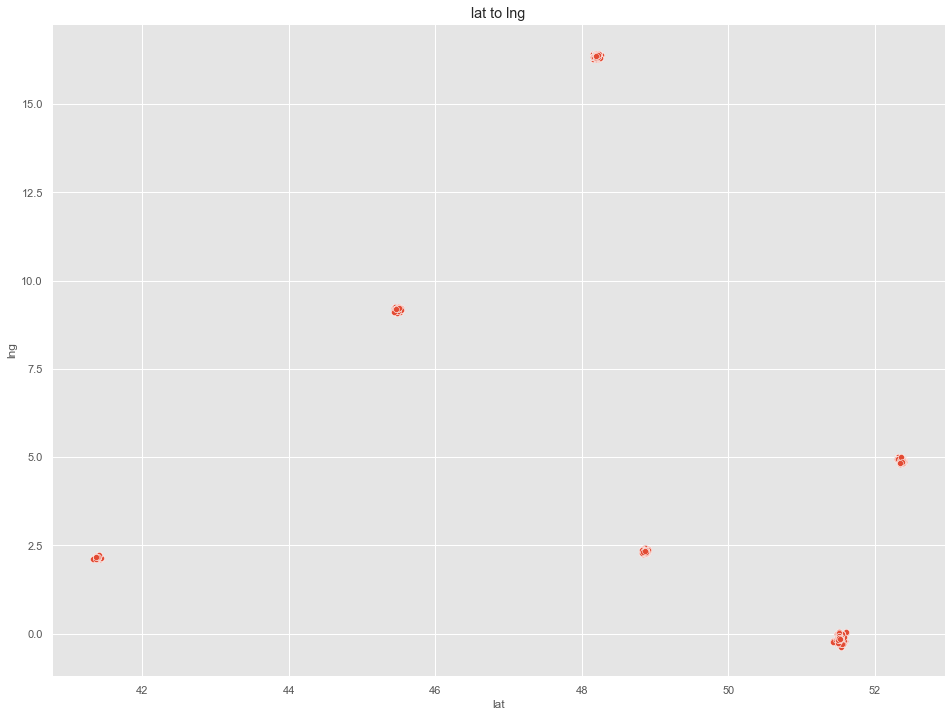

In [30]:
# Диаграмма рассеяния отлично показывает скопления координат. Фактически имеем 6 локаций где находятся отели
fig = plt.figure(figsize=(16, 12))
plot = sns.scatterplot(x=full_data['lat'], y=full_data['lng'])
plot.set_title('lat to lng')
fig.show()

In [31]:
# Заполняю пропуски по простому, медианой, это будет правое нижнее скопление
vals = {'lat': full_data['lat'].median(),
        'lng': full_data['lng'].median()}
full_data.fillna(value=vals, inplace=True)

### Изучаю hotel_address

In [32]:
# Визуальный анализ адресов показывает, что в самом конце идет название страны, перед этим город.
# Название страны из одного слова, кроме случаев United Kingdom, тогда город на 5ом месте с конца.
# df_full['hotel_address'].to_list()

Получения страны из адреса

In [33]:
# Функция для 
def country_feature(hotel_address):
    hotel_address = str(hotel_address)
    
    address_lst = hotel_address.split()
    
    last_word = address_lst[-1]
    
    if last_word == 'Kingdom':
        return 'United Kingdom'
    
    return last_word

In [34]:
full_data['country'] = full_data['hotel_address'].apply(country_feature)

In [35]:
# Получается всего 6 стран, country - это категориальный номинальный признак
full_data['country'].value_counts()

United Kingdom    262299
Spain              60149
France             59598
Netherlands        57212
Austria            38938
Italy              37206
Name: country, dtype: int64

In [36]:
# 50% отелей приходится на Великобританию
full_data['country'].value_counts(True) * 100

United Kingdom   50.89
Spain            11.67
France           11.56
Netherlands      11.10
Austria           7.55
Italy             7.22
Name: country, dtype: float64

In [37]:
# Страна это категориальный номинальный признак
full_data['country'] = full_data['country'].astype('category')

Получение города из адреса

In [38]:
def city_feature(hotel_address):
    hotel_address = str(hotel_address)
    
    address_lst = hotel_address.split()
    
    last_word = address_lst[-1]
    
    if last_word == 'Kingdom':
        return address_lst[-5]
    
    return address_lst[-2]

In [39]:
full_data['city'] = full_data['hotel_address'].apply(city_feature)

In [40]:
# Всего 6 городов, как и стран. Получается по городу в стране.
# Два эти признака полностью дублируют друг друга, но пока оставляю, ничего не удаляю.
# Сейчас идет генерация признаков, отбор и удаление будет позже.
full_data['city'].value_counts()

London       262299
Barcelona     60149
Paris         59598
Amsterdam     57212
Vienna        38938
Milan         37206
Name: city, dtype: int64

In [41]:
# Город это тоже категориальный номинальный признак
full_data['city'] = full_data['city'].astype('category')

### Страна и город
Могу получить дополнительный признак является ли город столицей

In [42]:
def is_capital_feature(city):
    # Складываю в список только столицы
    # Столица Италии - Рим, а не Милан
    # Столица Испании - Мадрид, а не Барселона
    capitals = ['London', 'Paris', 'Amsterdam', 'Vienna']
    
    if city in capitals:
        return True
    
    return False

In [43]:
full_data['is_capital'] = full_data['city'].apply(is_capital_feature)
full_data = full_data.convert_dtypes()

Признак hotel_address можно удалить, от туда уже ничего больше вытаскивать не буду.\
Город можно удалить, либо по городу и стране можно получить информацию по населению и выделить признак доля населения в % от страны приходящаяся на город. Насколько город большой.

In [44]:
full_data.drop('hotel_address', axis=1, inplace=True)

### Изучаю days_since_review

In [45]:
full_data['days_since_review'].describe()

count     515402
unique       731
top       1 days
freq        2584
Name: days_since_review, dtype: object

In [46]:
full_data['days_since_review'].unique()

<StringArray>
['531 day', '203 day', '289 day', '681 day', '516 day', '582 day', '77 days',
 '192 day', '618 day', '548 day',
 ...
 '251 day', '511 day', '125 day', '122 day', '477 day', '126 day', '701 day',
 '552 day', '257 day', '96 days']
Length: 731, dtype: string

In [47]:
# Функция для приведения признака к целому типа
def reformat_days_since_review(days_since_review):
    days_str = str(days_since_review)
    
    days = days_str.split()[0]
    
    return int(days)

In [48]:
full_data['days_since_review'] = full_data['days_since_review'].apply(reformat_days_since_review)

In [49]:
full_data['days_since_review'].describe()

count   515402.00
mean       354.40
std        208.91
min          0.00
25%        175.00
50%        353.00
75%        527.00
max        730.00
Name: days_since_review, dtype: float64

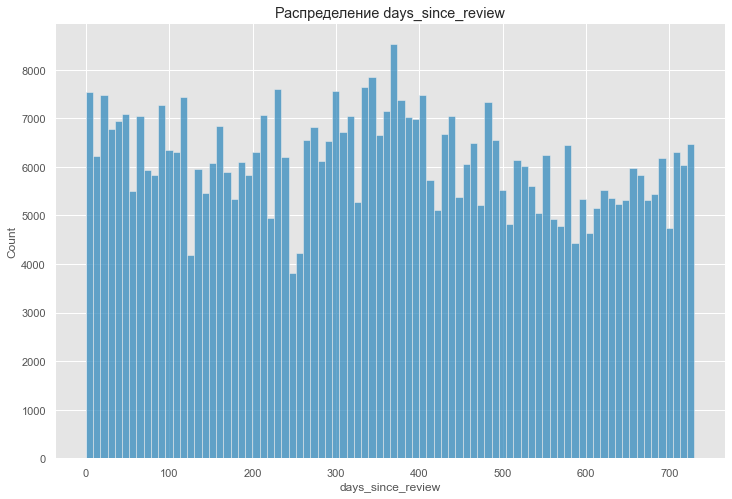

In [50]:
# Распределение похоже на забор, т.е. более-менее равномерно каждый день выставлялись оценки отелям
fig = plt.figure(figsize=(12, 8))
hist = sns.histplot(data=full_data, x='days_since_review')
hist.set_title('Распределение days_since_review');

In [51]:
full_data['days_since_review'].value_counts(True)

1     0.01
322   0.00
120   0.00
338   0.00
534   0.00
      ... 
327   0.00
615   0.00
122   0.00
124   0.00
123   0.00
Name: days_since_review, Length: 731, dtype: float64

### 0.8. Delete useless features

In [52]:
# убираем признаки которые еще не успели обработать, после приведения типов это string
string_columns = [col_name for col_name in full_data.columns if full_data[col_name].dtypes == 'string']

In [53]:
full_data.drop(string_columns, axis = 1, inplace=True)
print('Drop columns:', string_columns)

Drop columns: ['review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags']


### 0.9. Code features

In [54]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 15 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                515402 non-null  Int64   
 1   average_score                               515402 non-null  float64 
 2   review_total_negative_word_counts           515402 non-null  Int64   
 3   total_number_of_reviews                     515402 non-null  Int64   
 4   review_total_positive_word_counts           515402 non-null  Int64   
 5   total_number_of_reviews_reviewer_has_given  515402 non-null  Int64   
 6   days_since_review                           515402 non-null  int64   
 7   lat                                         515402 non-null  float64 
 8   lng                                         515402 non-null  float64 
 9   reviewer_score                              515402 non-null

### ONE-HOT ENCODING
Категориальные номинальные признаки

In [55]:
cols_to_ohe = ['country', 'city', 'is_capital']
full_data = pd.get_dummies(full_data, columns=cols_to_ohe, drop_first=False)

In [56]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515402 entries, 0 to 515737
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                515402 non-null  Int64   
 1   average_score                               515402 non-null  float64 
 2   review_total_negative_word_counts           515402 non-null  Int64   
 3   total_number_of_reviews                     515402 non-null  Int64   
 4   review_total_positive_word_counts           515402 non-null  Int64   
 5   total_number_of_reviews_reviewer_has_given  515402 non-null  Int64   
 6   days_since_review                           515402 non-null  int64   
 7   lat                                         515402 non-null  float64 
 8   lng                                         515402 non-null  float64 
 9   reviewer_score                              515402 non-null

### Ordinal Encoding
Порядковые категориальные признаки

### 0.9. Corralation analysis

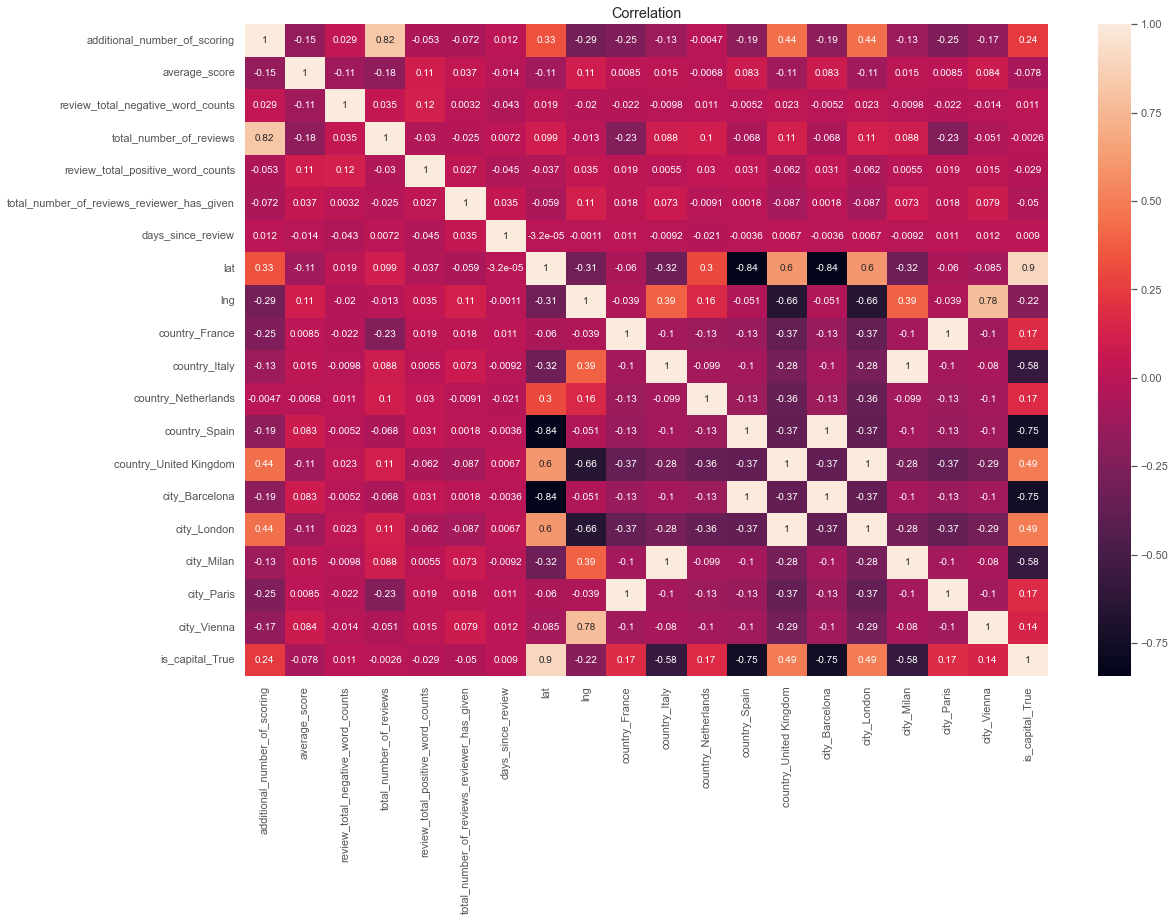

In [57]:
fig = plt.figure(figsize=(18, 12))
hm = sns.heatmap(full_data.drop(['dataset', TARGET_FEATURE], axis=1).corr(), annot=True)
hm.set_title('Correlation');

### 1.0. Split full dataset to train and test

In [58]:
train_data, test_data = hd.split_full_to_train_and_test(full_data)

### 1.1. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [123]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (21698, 15), te_data = (5425, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age
21115,21115,MERCEDES-BENZ,C 250,Sedan,156682,Automatic,4/5,Left wheel,White,NaN,WDDGF4HB6EA905229,1,For Sale,7500,7
17409,17409,VOLKSWAGEN,Passat,Sedan,92000,Automatic,4/5,Left wheel,Grey,Black,1VWAP7A34DC055330,0,For Sale,4600,9
20921,20921,FORD,Escape,Jeep,168966,Automatic,4/5,Left wheel,White,NaN,1FMCU5K31BKB48814,1,For Sale,1150,10
6598,6598,HYUNDAI,Sonata,Sedan,118643,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,6754,9
10439,10439,HYUNDAI,Elantra,Sedan,140000,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,4609,10


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [124]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [125]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In [126]:
automl = TabularAutoML(
# automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [127]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 0)

CPU times: total: 46min 48s
Wall time: 12min 57s


In [128]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.81405 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.18595 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [129]:
%%time
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[ 3441.752 ],
       [11478.221 ],
       [ 3606.0374],
       ...,
       [ 5871.615 ],
       [ 1594.9069],
       [ 4184.3193]], dtype=float32)
Shape = (5425, 1)
CPU times: total: 23.8 s
Wall time: 6.01 s


In [130]:
mae0 = mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])
print(f'TRAIN out-of-fold score: {mae0}')
experiment.log_metric('TRAIN out-of-fold score', mae0)


mae1 = mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])
print(f'HOLDOUT score: {mae1}')
experiment.log_metric('HOLDOUT score', mae1)

TRAIN out-of-fold score: 1217.0090492345932
HOLDOUT score: 1210.3088751633816


# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In [131]:
# %%time
# # Fast feature importances calculation
# fast_fi = automl.get_feature_scores('fast')
# fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [132]:
# %%time
# # Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
# accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

In [133]:
# accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

Для более точного предсказания использую весь датасет train_data

In [134]:
automl = TabularAutoML(
# automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [135]:
%%time 
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 0)

CPU times: total: 51min 29s
Wall time: 14min 14s


In [136]:
mae2 = mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])
print(f'FULL TRAIN score: {mae2}')
experiment.log_metric('FULL TRAIN score', mae2)

FULL TRAIN score: 1161.7015939214507


In [137]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 2928.0444],
       [ 5643.253 ],
       [ 2320.2744],
       ...,
       [10300.769 ],
       [ 5064.375 ],
       [ 6414.238 ]], dtype=float32)
Shape = (10697, 1)


In [138]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission

,row_ID,final_price
0,35000,2928.04
1,35001,5643.25
2,35002,2320.27
3,35003,2126.17
4,35004,5045.77
...,...,...
10692,45692,988.49
10693,45693,1294.45
10694,45694,10300.77
10695,45695,5064.38


### Проверка и замена нулевой записи

In [139]:
# Должно быть ноль
submission[submission['row_ID'] == 37254]

,row_ID,final_price
2254,37254,2768.71


In [140]:
# Если не ноль, то принудительно меняю
ind = submission[submission['row_ID'] == 37254].index
submission.at[ind[0], 'final_price'] = 0

In [141]:
submission.to_csv(submission_file_name, index = False)

In [142]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/chepell/predict-car-price/23cda242c5d445f2b20c168e6ed08ca7
COMET INFO:   Metrics:
COMET INFO:     FULL TRAIN score        : 1161.7015939214507
COMET INFO:     HOLDOUT score           : 1210.3088751633816
COMET INFO:     TRAIN out-of-fold score : 1217.0090492345932
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (406.20 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO:     text-sample              : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functional